# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext Ddip
%makedip -g all -a fastai_v1 --verbose=True


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


Proc [24796] Connecting to ipyparallel cluster.......

Proc [24796] Initializing torch distributed group with GPUs [0, 1, 2]
Proc [24796] Local Ranks initialized:  ['GPU0=0', 'GPU1=1', 'GPU2=2']
Proc [24796] Importing on cluster: ['import fastai, fastai.torch_core, torch, fastprogress', 'from fastai.distributed import *', 'from Ddip.fastai_v1 import initializer, finalizer, set_verbose, lr_find_bypass']
Proc [24796]
fastai_v1:
[Process 24852] Rank 0 fastai initialized for distributed data parallel.
[Process 24856] Rank 1 fastai initialized for distributed data parallel.
[Process 24859] Rank 2 fastai initialized for distributed data parallel.


In [2]:
%%dip everywhere
from fastai.vision import *

%%dip everywhere: Running cell in local namespace.
%%dip everywhere: Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [6]:
doc(get_transforms)

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [8]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
%dipush bs path tfms src get_data
%autodip on

Pushing parameters to DDP namespace: ['bs', 'path', 'tfms', 'src', 'get_data']
Auto Execution on DDP group: on, will run cell as %%dip


In [10]:
data = get_data(224, bs, 'zeros')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

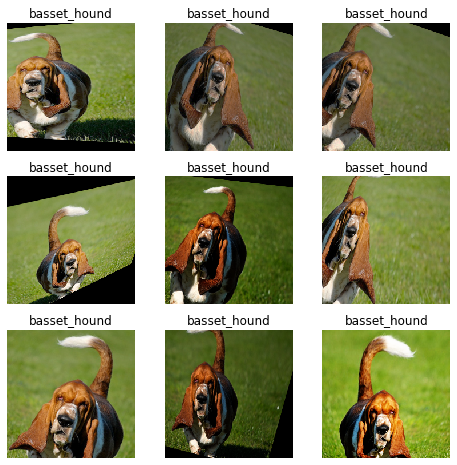

In [11]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [12]:
data = get_data(224,bs)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

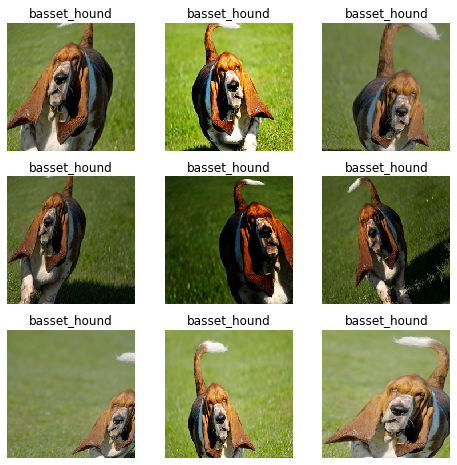

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [14]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         2.281569    0.303842    0.100068    00:23                                      
1         1.477012    0.211650    0.077079    00:23                                      
2         1.098220    0.222068    0.069642    00:23                                      


In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         0.678613    0.242317    0.066261    00:24                                      
1         0.642448    0.223045    0.064909    00:24                                      


In [17]:
data = get_data(352,bs)
learn.data = data

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.543211,0.203855,0.051421,00:46
1,0.484424,0.202989,0.052774,00:44


In [21]:
learn.save('352')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


## Convolution kernel

In [22]:
data = get_data(352,16)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [23]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

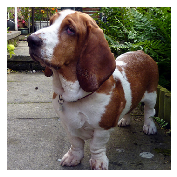

Out[0:14]: Category basset_hound

In [24]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [25]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [26]:
k

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:16]: 
tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [27]:
k.shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:17]: torch.Size([1, 3, 3, 3])

In [28]:
t = data.valid_ds[0][0].data; t.shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:18]: torch.Size([3, 352, 352])

In [29]:
t[None].shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:19]: torch.Size([1, 3, 352, 352])

In [30]:
edge = F.conv2d(t[None], k)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

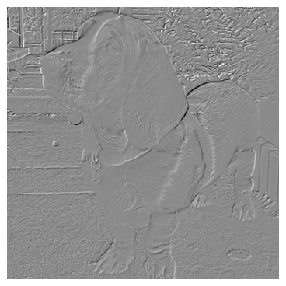

In [31]:
show_image(edge[0], figsize=(5,5));

In [32]:
data.c

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:22]: 37

In [33]:
learn.model

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:23]: 
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [34]:
print(learn.summary())

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0        

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [35]:
m = learn.model.eval();

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [36]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [37]:
from fastai.callbacks.hooks import *

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [38]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [39]:
hook_a,hook_g = hooked_backward()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [40]:
acts  = hook_a.stored[0].cpu()
acts.shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:30]: torch.Size([512, 11, 11])

In [41]:
avg_acts = acts.mean(0)
avg_acts.shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:31]: torch.Size([11, 11])

In [42]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

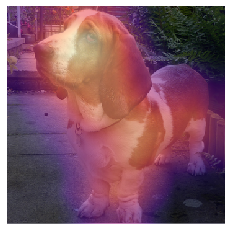

In [43]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [44]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:34]: (torch.Size([512, 11, 11]), torch.Size([512]))

In [45]:
mult = (acts*grad_chan[...,None,None]).mean(0)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

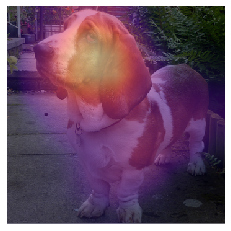

In [46]:
show_heatmap(mult)

In [47]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [48]:
x = open_image(fn); x

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


RemoteError: FileNotFoundError([Errno 2] No such file or directory: '/home/ndim1/.fastai/data/oxford-iiit-pet/other/bulldog_maine.jpg')

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

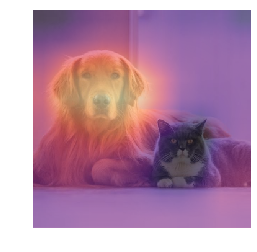

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

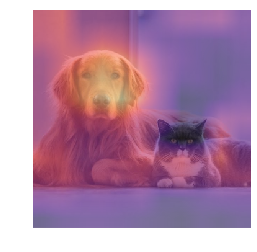

In [ ]:
show_heatmap(mult)

## fin